In [8]:
import string
import nltk
import numpy as numpy
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem.porter import *
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer

stemmer = PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def get_tokens(text):
    lowers = text.lower()
    no_punctuation = lowers.translate(remove_punctuation_map)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    return stemmed

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_path = '/content/drive/My Drive/Colab Notebooks/Lab1/24_train_1.csv'
data = pd.read_csv(data_path)
processed_docs = [get_tokens(articles) for articles in data['Text']]
processed_docs_str = [' '.join(doc) for doc in processed_docs]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(processed_docs_str)
y = data['Category']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
criteria = ['gini', 'entropy']
criterion_values = ["Training Accuracy", "Validation Accuracy"]
training_accuracies = []
validation_accuracies = []
gini_accuracies = []
entropy_accuracies = []

for criterion in criteria:
    clf = DecisionTreeClassifier(criterion=criterion, random_state=42)
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    training_accuracies.append(train_acc)
    val_pred = clf.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    validation_accuracies.append(val_acc)
    if criterion=='gini':
        gini_accuracies.append(train_acc)
        gini_accuracies.append(val_acc)

    else:
        entropy_accuracies.append(train_acc)
        entropy_accuracies.append(val_acc)
print("Training Accuracies: ", training_accuracies)
print("Validation Accuracies: ", validation_accuracies)

Training Accuracies:  [1.0, 1.0]
Validation Accuracies:  [0.81, 0.73]


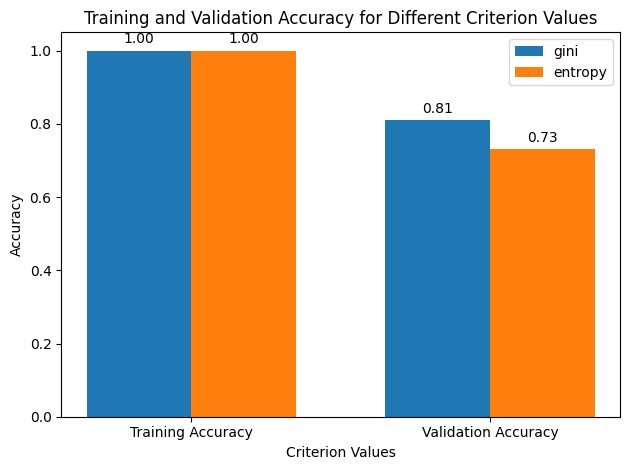

In [10]:
bar_width = 0.35
index = numpy.arange(len(criteria))
fig, ax = plt.subplots()
gini_bars = ax.bar(index, gini_accuracies, bar_width, label='gini')
entropy_bars = ax.bar(index + bar_width, entropy_accuracies, bar_width, label='entropy')
ax.set_xlabel('Criterion Values')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy for Different Criterion Values')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(criterion_values)
ax.legend()
for bar in gini_bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

for bar in entropy_bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [11]:
X = vectorizer.fit_transform(processed_docs_str)
y = data['Category']
min_samples_leaf_values = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200 ]
train_accuracies = []
test_accuracies = []
train_std = []
test_std = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for min_samples in min_samples_leaf_values:
    clf = DecisionTreeClassifier(min_samples_leaf=min_samples, random_state=42)
    train_fold_accuracies = []
    test_fold_accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        train_fold_accuracies.append(accuracy_score(y_train, y_train_pred))
        y_test_pred = clf.predict(X_test)
        test_fold_accuracies.append(accuracy_score(y_test, y_test_pred))
    train_accuracies.append(numpy.mean(train_fold_accuracies))
    test_accuracies.append(numpy.mean(test_fold_accuracies))
    train_std.append(numpy.std(train_fold_accuracies))
    test_std.append(numpy.std(test_fold_accuracies))
results = pd.DataFrame({
    'min_samples_leaf': min_samples_leaf_values,
    'training accuracy': train_accuracies,
    'validation accuracy': test_accuracies,
    'training std': train_std,
    'validation std': test_std
})
print(results)

   min_samples_leaf  training accuracy  validation accuracy  training std  \
0                20            0.80400                0.719      0.009062   
1                40            0.73650                0.684      0.018631   
2                60            0.70575                0.660      0.016481   
3                80            0.64175                0.589      0.024026   
4               100            0.60350                0.551      0.024075   
5               120            0.51800                0.484      0.017493   
6               140            0.50600                0.474      0.017274   
7               160            0.43950                0.402      0.016782   
8               180            0.43000                0.419      0.030781   
9               200            0.38125                0.372      0.014620   

   validation std  
0        0.030232  
1        0.046087  
2        0.050695  
3        0.041761  
4        0.032465  
5        0.033076  
6        0.0

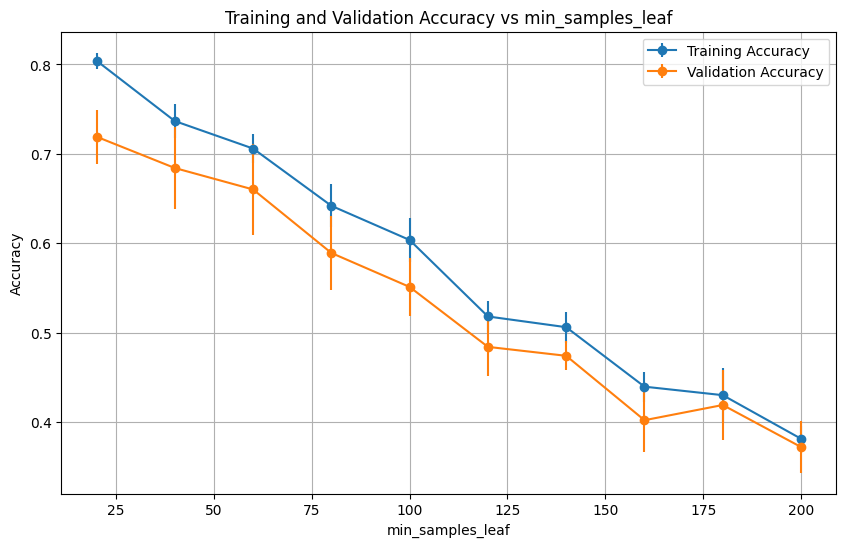

In [12]:
plt.figure(figsize=(10, 6))
plt.errorbar(min_samples_leaf_values, train_accuracies, yerr=train_std, label='Training Accuracy', fmt='-o')
plt.errorbar(min_samples_leaf_values, test_accuracies, yerr=test_std, label='Validation Accuracy', fmt='-o')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs min_samples_leaf')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
X = vectorizer.fit_transform(processed_docs_str)
y = data['Category']

max_features_values = [x for x in range(0,1050,50)]
max_features_values[0]=1
train_accuracies = []
test_accuracies = []
train_std = []
test_std = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for max_features in max_features_values:
    clf = DecisionTreeClassifier(max_features=max_features, random_state=42)
    train_fold_accuracies = []
    test_fold_accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        train_fold_accuracies.append(accuracy_score(y_train, y_train_pred))
        y_test_pred = clf.predict(X_test)
        test_fold_accuracies.append(accuracy_score(y_test, y_test_pred))
    train_accuracies.append(numpy.mean(train_fold_accuracies))
    test_accuracies.append(numpy.mean(test_fold_accuracies))
    train_std.append(numpy.std(train_fold_accuracies))
    test_std.append(numpy.std(test_fold_accuracies))

results = pd.DataFrame({
    'max_features': max_features_values,
    'training accuracy': train_accuracies,
    'validation accuracy': test_accuracies,
    'training std': train_std,
    'validation std': test_std
})
print(results)

    max_features  training accuracy  validation accuracy  training std  \
0              1                1.0                0.458           0.0   
1             50                1.0                0.520           0.0   
2            100                1.0                0.565           0.0   
3            150                1.0                0.561           0.0   
4            200                1.0                0.569           0.0   
5            250                1.0                0.608           0.0   
6            300                1.0                0.580           0.0   
7            350                1.0                0.609           0.0   
8            400                1.0                0.589           0.0   
9            450                1.0                0.578           0.0   
10           500                1.0                0.619           0.0   
11           550                1.0                0.657           0.0   
12           600                1.0   

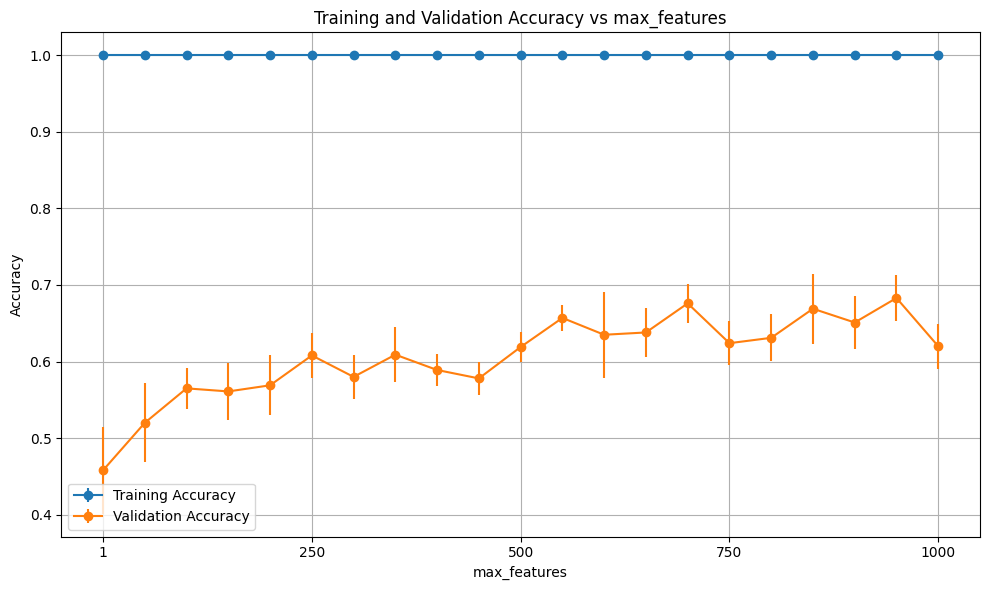

In [14]:
max_features_labels = [str(val) for val in max_features_values]
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(max_features_values)), train_accuracies, yerr=train_std, label='Training Accuracy', fmt='-o')
plt.errorbar(range(len(max_features_values)), test_accuracies, yerr=test_std, label='Validation Accuracy', fmt='-o')
plt.xticks(ticks=range(0, len(max_features_values), 5), labels=[max_features_labels[i] for i in range(0, len(max_features_values), 5)])
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs max_features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
X = vectorizer.fit_transform(processed_docs_str)
y = data['Category']
n_estimators_values = [x for x in range(0,210,10)]
n_estimators_values[0]=1
train_accuracies_n = []
test_accuracies_n = []
train_std_n = []
test_std_n = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for n_estimators in n_estimators_values:
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    train_fold_accuracies = []
    test_fold_accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        train_fold_accuracies.append(accuracy_score(y_train, y_train_pred))
        y_test_pred = clf.predict(X_test)
        test_fold_accuracies.append(accuracy_score(y_test, y_test_pred))

    train_accuracies_n.append(numpy.mean(train_fold_accuracies))
    test_accuracies_n.append(numpy.mean(test_fold_accuracies))
    train_std_n.append(numpy.std(train_fold_accuracies))
    test_std_n.append(numpy.std(test_fold_accuracies))
results_n = pd.DataFrame({
    'n_estimators': n_estimators_values,
    'training accuracy': train_accuracies_n,
    'validation accuracy': test_accuracies_n,
    'training std': train_std_n,
    'validation std': test_std_n
})
print(results_n)

    n_estimators  training accuracy  validation accuracy  training std  \
0              1            0.82300                0.546      0.022369   
1             10            0.99875                0.848      0.001581   
2             20            0.99975                0.907      0.000500   
3             30            1.00000                0.922      0.000000   
4             40            1.00000                0.928      0.000000   
5             50            1.00000                0.930      0.000000   
6             60            1.00000                0.934      0.000000   
7             70            1.00000                0.942      0.000000   
8             80            1.00000                0.940      0.000000   
9             90            1.00000                0.941      0.000000   
10           100            1.00000                0.934      0.000000   
11           110            1.00000                0.942      0.000000   
12           120            1.00000   

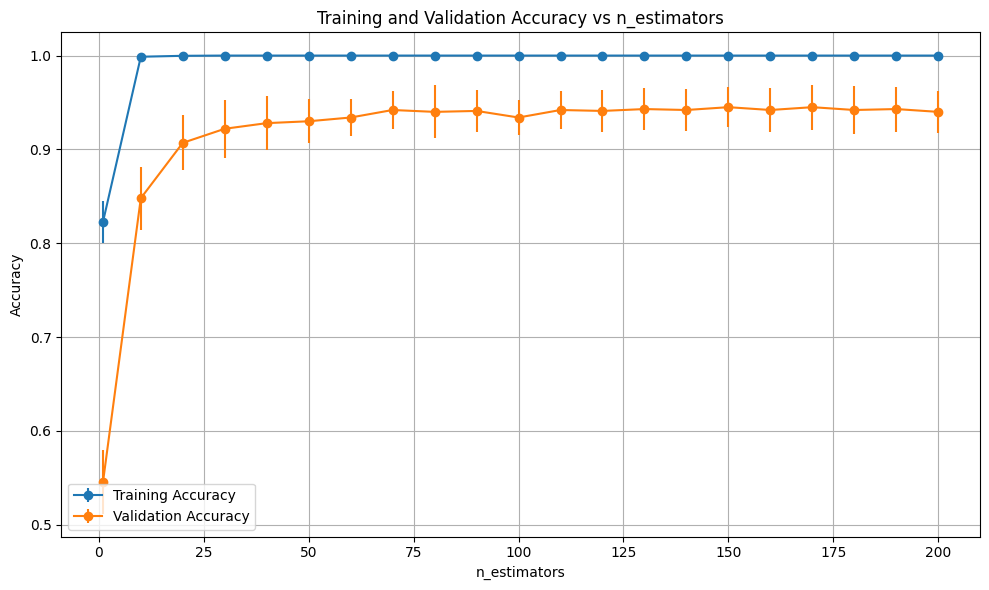

In [16]:
plt.figure(figsize=(10, 6))
plt.errorbar(n_estimators_values, train_accuracies_n, yerr=train_std_n, label='Training Accuracy', fmt='-o')
plt.errorbar(n_estimators_values, test_accuracies_n, yerr=test_std_n, label='Validation Accuracy', fmt='-o')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
min_samples_leaf_values =  [x for x in range(0,210,10)]
min_samples_leaf_values[0]=1
train_accuracies_leaf = []
test_accuracies_leaf = []
train_std_leaf = []
test_std_leaf = []

for min_samples_leaf in min_samples_leaf_values:
    clf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, random_state=42)
    train_fold_accuracies = []
    test_fold_accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        train_fold_accuracies.append(accuracy_score(y_train, y_train_pred))
        y_test_pred = clf.predict(X_test)
        test_fold_accuracies.append(accuracy_score(y_test, y_test_pred))

    train_accuracies_leaf.append(numpy.mean(train_fold_accuracies))
    test_accuracies_leaf.append(numpy.mean(test_fold_accuracies))
    train_std_leaf.append(numpy.std(train_fold_accuracies))
    test_std_leaf.append(numpy.std(test_fold_accuracies))
results_leaf = pd.DataFrame({
    'min_samples_leaf': min_samples_leaf_values,
    'training accuracy': train_accuracies_leaf,
    'validation accuracy': test_accuracies_leaf,
    'training std': train_std_leaf,
    'validation std': test_std_leaf
})
print(results_leaf)

    min_samples_leaf  training accuracy  validation accuracy  training std  \
0                  1            1.00000                0.934      0.000000   
1                 10            0.94550                0.897      0.005037   
2                 20            0.79225                0.737      0.041468   
3                 30            0.60650                0.546      0.051097   
4                 40            0.43625                0.396      0.059034   
5                 50            0.35650                0.345      0.076135   
6                 60            0.33500                0.330      0.068834   
7                 70            0.32050                0.300      0.066458   
8                 80            0.30900                0.291      0.058967   
9                 90            0.28425                0.273      0.048917   
10               100            0.27875                0.271      0.050664   
11               110            0.27375                0.271    

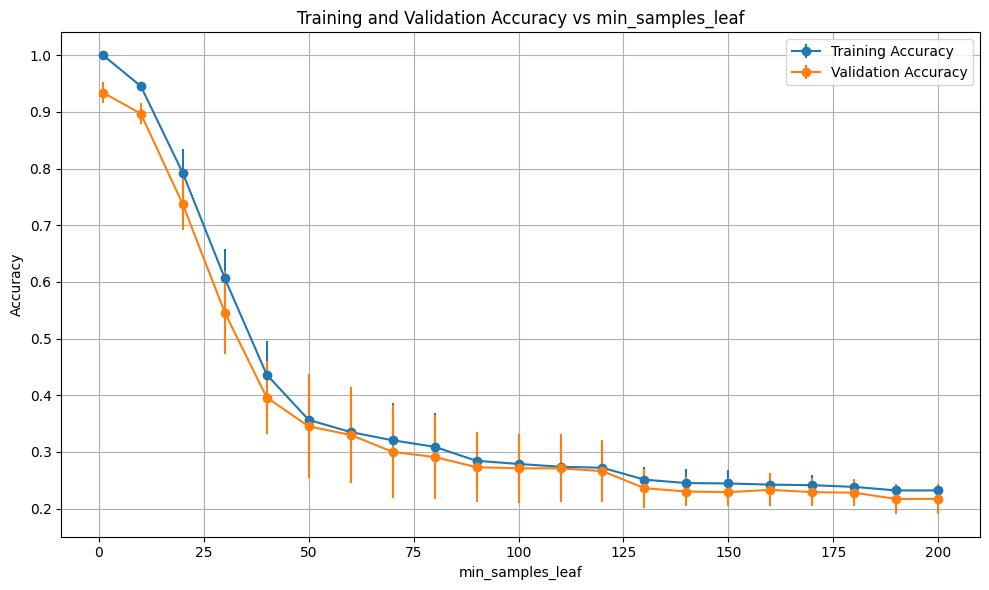

In [18]:
plt.figure(figsize=(10, 6))
plt.errorbar(min_samples_leaf_values, train_accuracies_leaf, yerr=train_std_leaf, label='Training Accuracy', fmt='-o')
plt.errorbar(min_samples_leaf_values, test_accuracies_leaf, yerr=test_std_leaf, label='Validation Accuracy', fmt='-o')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs min_samples_leaf')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
drive.mount('/content/drive')
training_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Lab1/24_train_1.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Lab1/news-test.csv')
def preprocess_text(text):
    lowers = text.lower()
    no_punctuation = lowers.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(no_punctuation)
    filtered_tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(filtered_tokens)

training_data['Processed_Text'] = training_data['Text'].apply(preprocess_text)
test_data['Processed_Text'] = test_data['Text'].apply(preprocess_text)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(training_data['Processed_Text'])
X_test = vectorizer.transform(test_data['Processed_Text'])

y_train = training_data['Category']
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Model: {best_model}")
train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
test_pred = best_model.predict(X_test)
output = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Predicted_Category': test_pred})
output.to_csv('/content/drive/My Drive/Colab Notebooks/Lab1/labels.csv', index=False, header=False)
print("Predictions saved.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best Model: RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42)
Predictions saved.
